In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

In [3]:
# Load in metadata
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
# Rename category "Cocktail dress / Party dress" to "Cocktail dress" to avoid problems in path definitions
meta['category'] = meta['category'].replace('Cocktail dress / Party dress', 'Cocktail dress')
# Rename "3/4 length" to "34 length" to avoid problems in path definitions
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')

### Helper Functions

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [6]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [7]:
def generate_pti(latent, G_PTI):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = tensor2im(gen.squeeze(0))
    return img

In [8]:
def get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)

    boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")
    boundary = torch.tensor(boundary)
    for i in range(steps):
        latent_code[i, :, :] = latent_code[i, :, :] + linspace[i] * boundary
    
    return latent_code

In [9]:
def run_example(attribute, att1, att2, steps=5, distance=15, dims_to_change=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):

    try:
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")

    except:
        att1, att2 = att2, att1
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"

    # Load in Metadata
    df = pd.read_csv(f"{input_base_dir}metadata.csv")
    training_stats = pd.read_csv(f"{boundaries_base_dir}summary_stats.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Sample one latent
    sample = df.sample(1)
    latent_code = latents[sample.sku.item()].squeeze(0).flatten()

    # Generate Interpolations
    if sample.label.item() == 0: 
        start_distance, end_distance = 0, distance
    elif sample.label.item() == 1: 
        start_distance, end_distance = -distance,  0

    interpolations = get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir)

    imgs = [generate_from_latent(interpolations[i, :, :].squeeze(0).reshape(1,16,512)) for i in range(steps)]
    fig, ax = plt.subplots(1, steps, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
        ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

    fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()} \n{att1} <-> {att2}\nBoundary Acc: {np.round(training_stats.acc.item(), 2)}")
    plt.show()

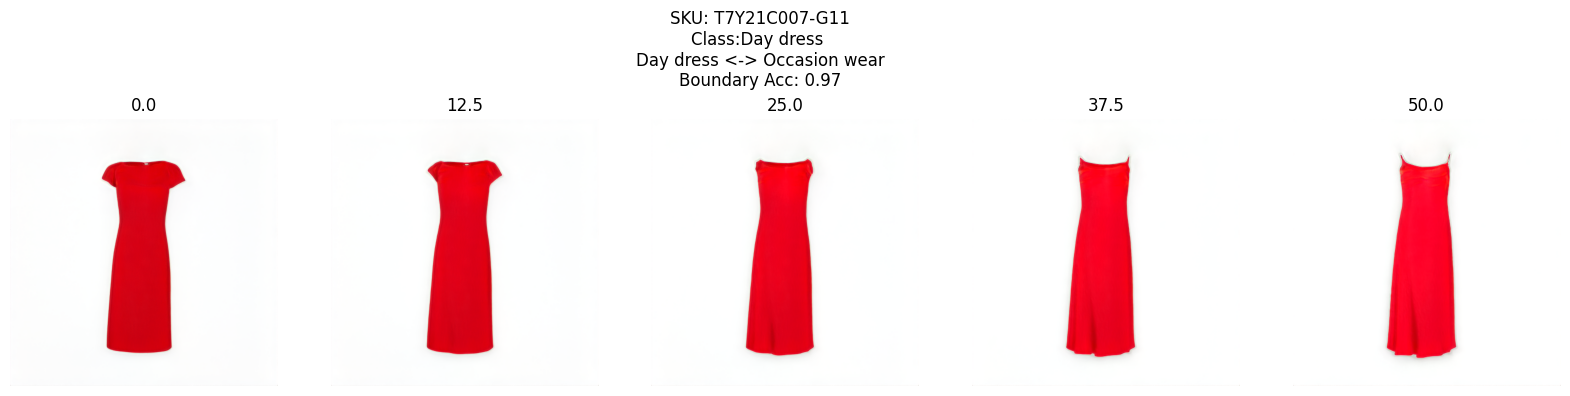

In [12]:
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'

run_example(attribute, att1, att2, steps=5, distance=50)

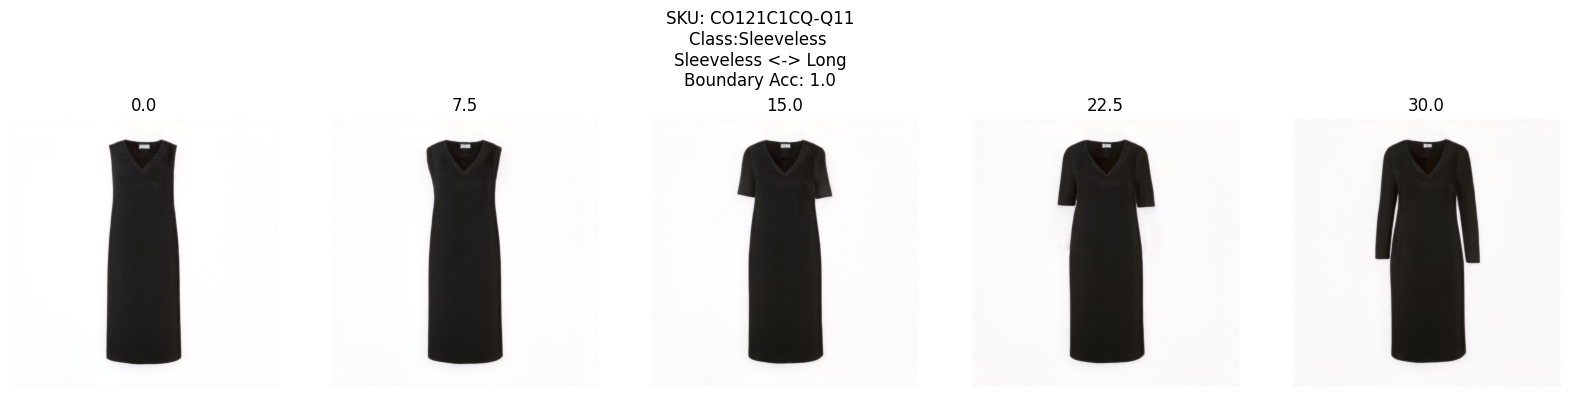

In [22]:
attribute = 'sleeve_length'
att1 = 'Long'
att2 = 'Sleeveless'

run_example(attribute, att1, att2, steps=5, distance=30)

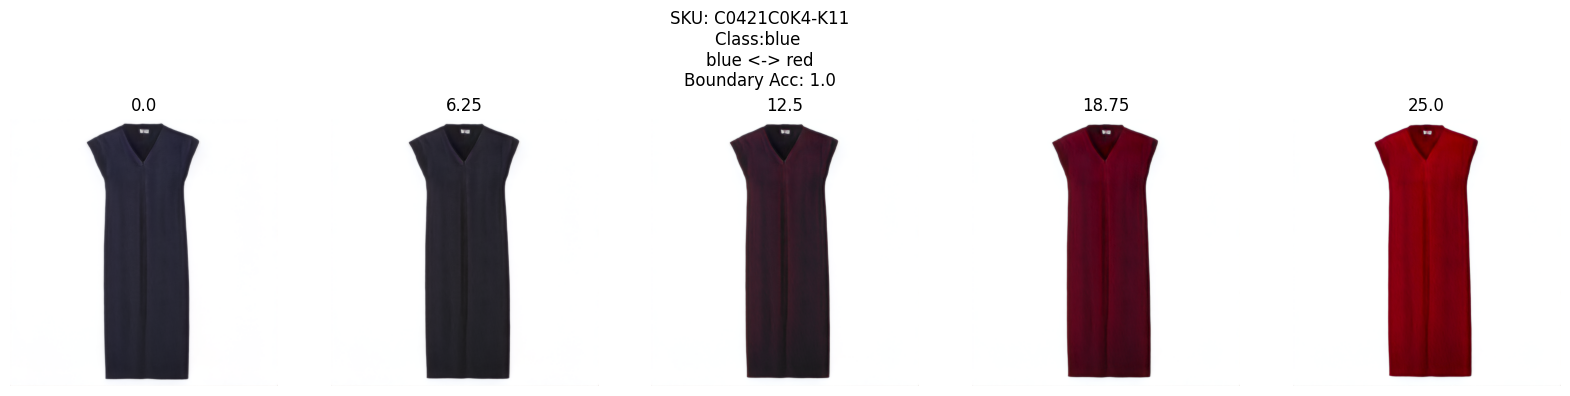

In [23]:
attribute = 'color'
att1 = 'blue'
att2 = 'red'

run_example(attribute, att1, att2, steps=5, distance=25)

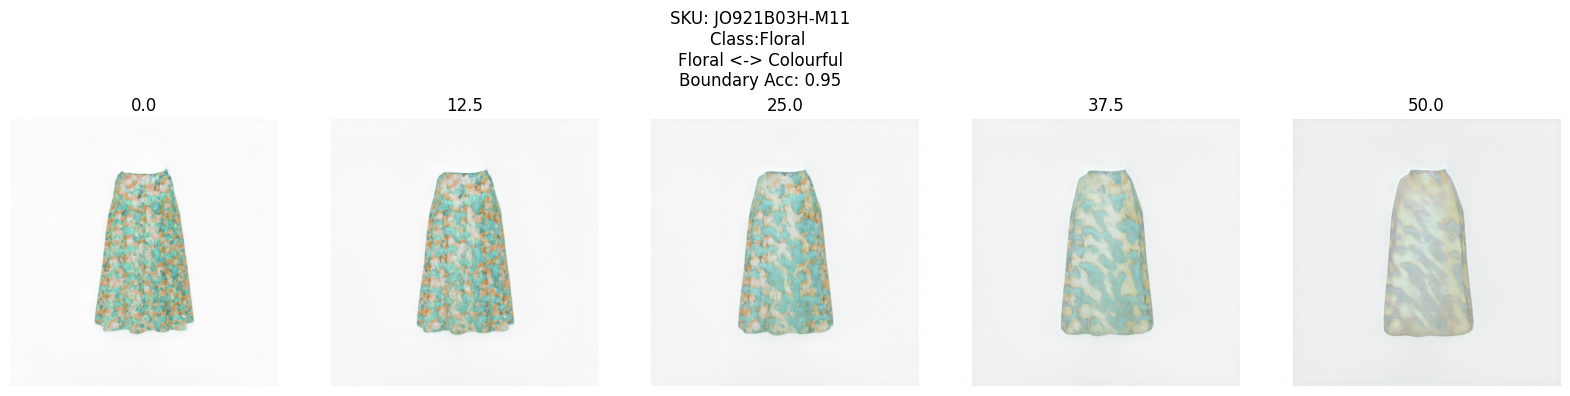

In [45]:
attribute = 'pattern'
att1 = 'Colourful'
att2 = 'Floral'

run_example(attribute, att1, att2, steps=5, distance=50)

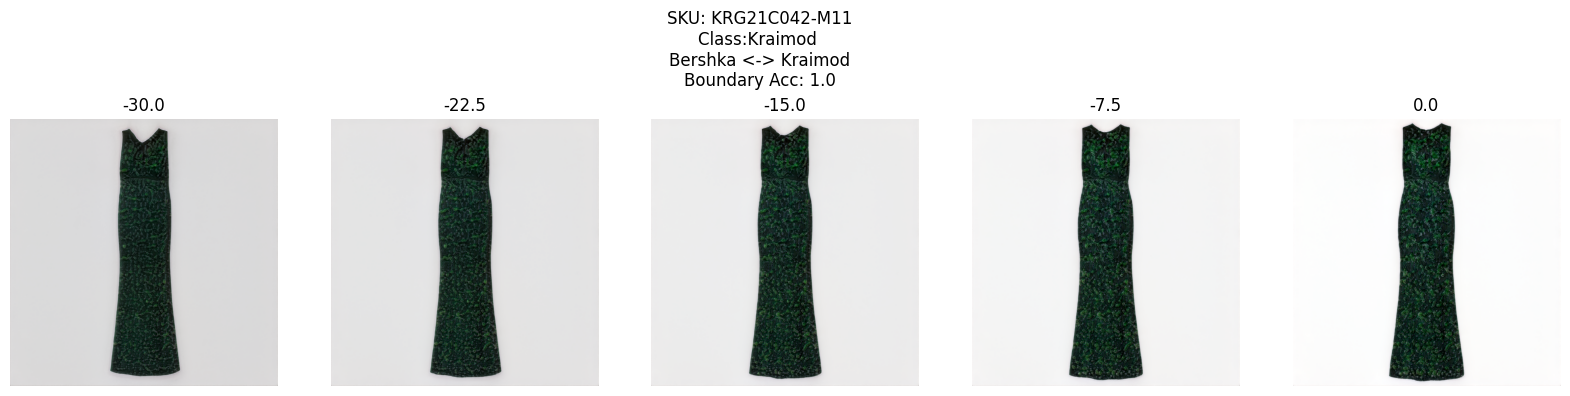

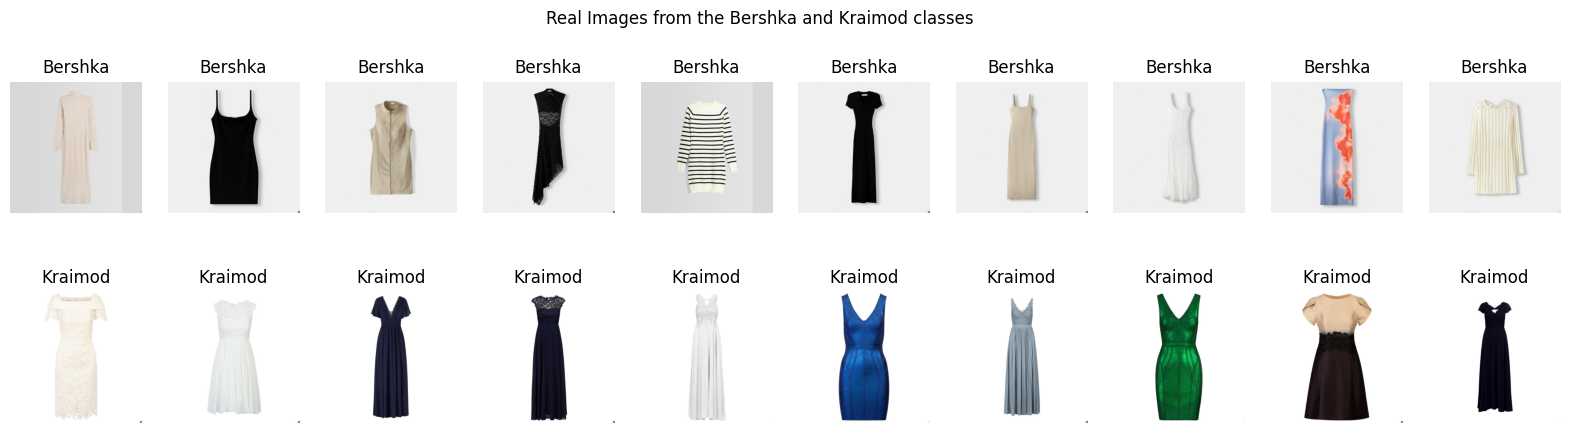

In [13]:
attribute = 'brand'
att1 = 'Bershka'
att2 = 'Kraimod'

run_example(attribute, att1, att2, distance = 30)

# Plot some examples from the two classes to visually inspect the classes
n = 10
att1_samples = meta[meta[attribute] == att1].sample(n).sku.to_list()
att2_samples = meta[meta[attribute] == att2].sample(n).sku.to_list()

fig, ax = plt.subplots(2, n, figsize=(20, 5))
for i in range(n):
    ax[0, i].imshow(Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{att1_samples[i]}.jpg"))
    ax[0, i].axis('off')
    ax[0, i].set_title(att1)
    ax[1, i].imshow(Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{att2_samples[i]}.jpg"))
    ax[1, i].axis('off')
    ax[1, i].set_title(att2)
fig.suptitle(f'Real Images from the {att1} and {att2} classes')
plt.show()

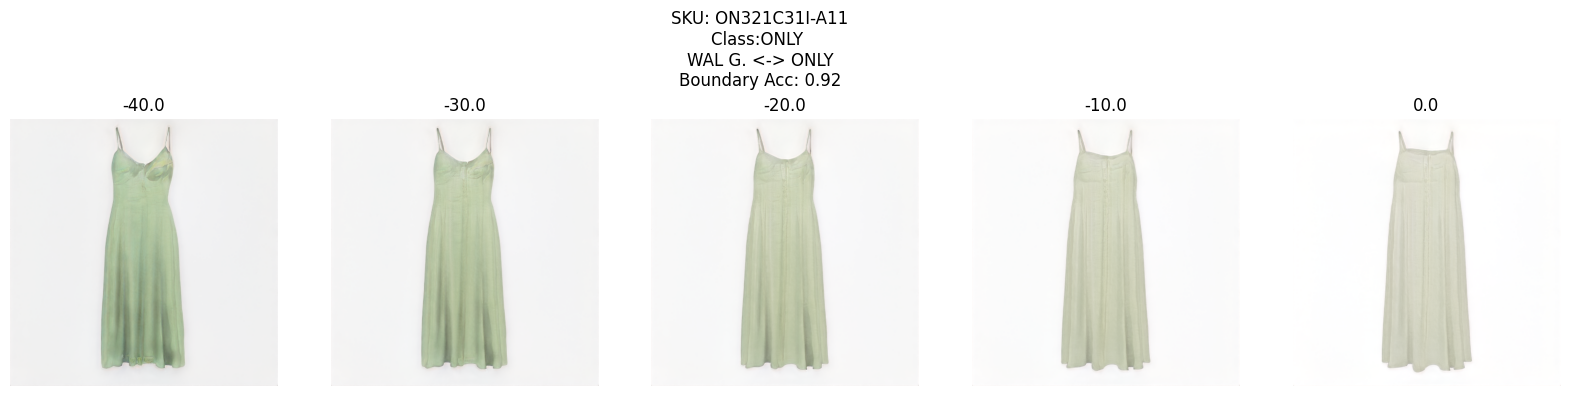

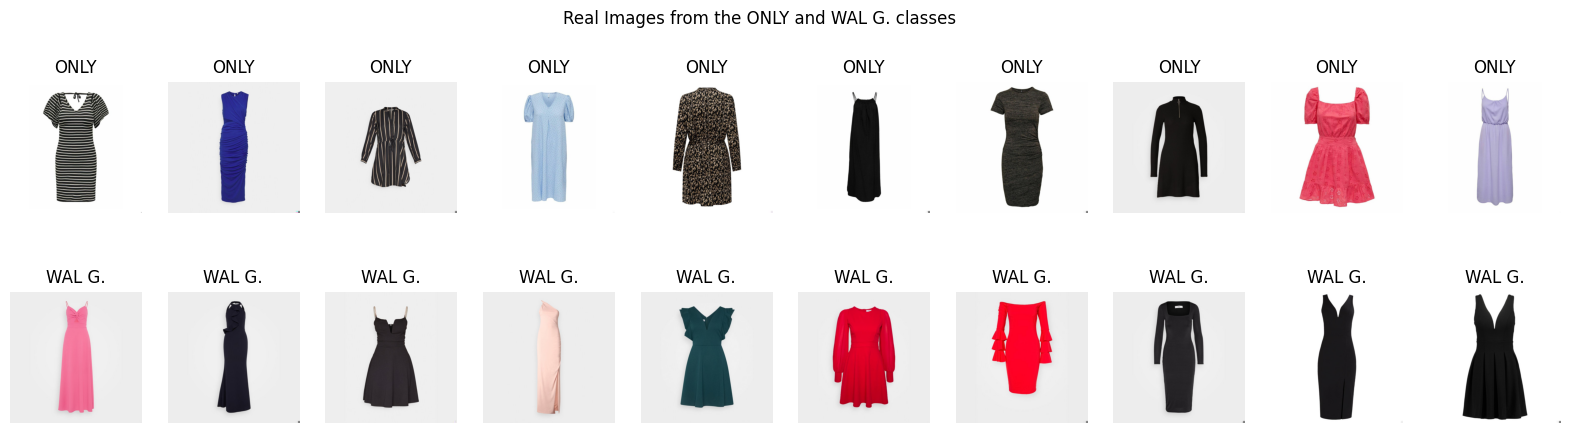

In [14]:
attribute = 'brand'
att1 = 'ONLY'
att2 = 'WAL G.'

run_example(attribute, att1, att2, distance = 40)

# Plot some examples from the two classes to visually inspect the classes
n = 10
att1_samples = meta[meta[attribute] == att1].sample(n).sku.to_list()
att2_samples = meta[meta[attribute] == att2].sample(n).sku.to_list()

fig, ax = plt.subplots(2, n, figsize=(20, 5))
for i in range(n):
    ax[0, i].imshow(Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{att1_samples[i]}.jpg"))
    ax[0, i].axis('off')
    ax[0, i].set_title(att1)
    ax[1, i].imshow(Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{att2_samples[i]}.jpg"))
    ax[1, i].axis('off')
    ax[1, i].set_title(att2)
fig.suptitle(f'Real Images from the {att1} and {att2} classes')
plt.show()

### Plots for the paper

In [10]:
def get_manipulations(attribute, att1, att2, steps=5, distance=15, dims_to_change=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):

    try:
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")

    except:
        att1, att2 = att2, att1
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"

    # Load in Metadata
    df = pd.read_csv(f"{input_base_dir}metadata.csv")
    training_stats = pd.read_csv(f"{boundaries_base_dir}summary_stats.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Sample one latent
    sample = df.sample(1)
    latent_code = latents[sample.sku.item()].squeeze(0).flatten()

    # Generate Interpolations
    if sample.label.item() == 0: 
        start_distance, end_distance = 0, distance
    elif sample.label.item() == 1: 
        start_distance, end_distance = -distance,  0

    interpolations = get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir)

    imgs = [generate_from_latent(interpolations[i, :, :].squeeze(0).reshape(1,16,512)) for i in range(steps)]
    return imgs

In [15]:
attribute = 'color'
att1 = 'blue'
att2 = 'red'

imgs = get_manipulations(attribute, att1, att2, steps=5, distance=40)

In [50]:
experiments = {
    0:('color', 'blue', 'red'), 
    1:('color', 'red','green'),
    2:('sleeve_length', 'Sleeveless', 'Long'), 
    3:('sleeve_length', 'Long', 'Short')
}

In [53]:
from tqdm import tqdm
results = {}
for index, config in tqdm(experiments.items()):
    imgs = get_manipulations(config[0], config[1], config[2], steps = 5, distance = 30)
    results[index] = imgs

100%|██████████| 4/4 [00:36<00:00,  9.06s/it]


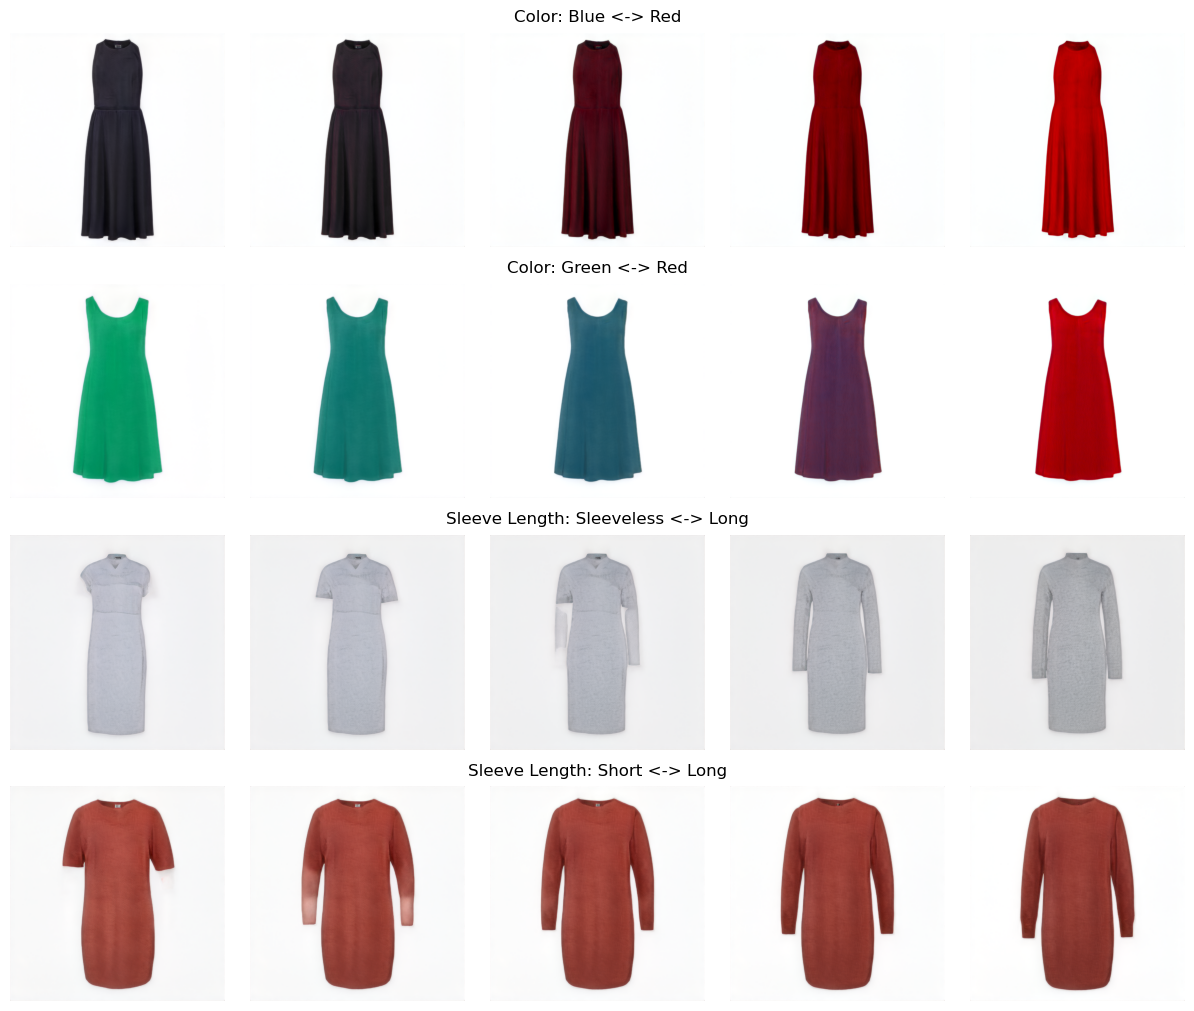

In [55]:
titles = ['Color: Blue <-> Red', 'Color: Green <-> Red', 'Sleeve Length: Sleeveless <-> Long', 'Sleeve Length: Short <-> Long']
fig = plt.figure(constrained_layout=True, figsize=(12,10))
subfigs = fig.subfigures(nrows=4, ncols=1)
for i, subfig in enumerate(subfigs):
    config = experiments[i]
    subfig.suptitle(titles[i])

    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        ax.imshow(results[i][col])
        ax.axis('off')